In [1]:
import sys  
sys.path.insert(0, '../')
from tools.training import make_training, test_on_dataset
from imagenet_models.alexnet import alexnet

import torch.nn as nn
import torch

In [2]:
variation = "mixed_same"

In [3]:
net = alexnet(pretrained=False, progress=True, num_classes = 9)

using cuda



Finished Training
Final acc :  98.88888888888889

Accuracy Graph


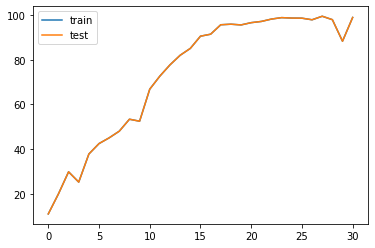


Loss Graph


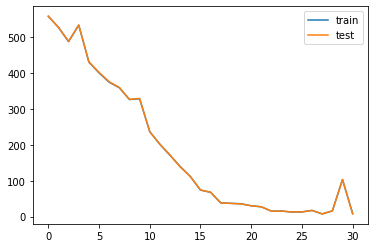

In [4]:
make_training(variation = variation, net = net, nb_epoch = 30, batch_size = 16, workers = 0, criterion = nn.CrossEntropyLoss(), test_acc_period = 10, _print = False)

In [5]:
PATH = "../models/AlexNet_"+ variation + ".pt"
torch.save(net.state_dict(), PATH)

In [6]:
for variation in ["original","mixed_same", "mixed_next", "mixed_rand", "no_fg", "only_bg_b", "only_bg_t", "only_fg"] :
    acc = test_on_dataset(variation = variation, net=net)
    print("Accuracy on ", variation, " : ", acc)

Accuracy on  original  :  56.54320987654321
Accuracy on  mixed_same  :  98.88888888888889
Accuracy on  mixed_next  :  40.98765432098765
Accuracy on  mixed_rand  :  44.44444444444444
Accuracy on  no_fg  :  24.271604938271604
Accuracy on  only_bg_b  :  21.679012345679013
Accuracy on  only_bg_t  :  35.58024691358025
Accuracy on  only_fg  :  31.28395061728395
